# ビジネス課題
電力データの分析によって、配達前に在宅しているかをどうかを判別して、再配達を減らす

# KPI
再配達数を減少させること

# 分析手法
クラスタリング手法を用いて、時間帯における電力消費が似ているクライアントをグルーピングして傾向を割り出す

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 前処理
- データのロード
- クライアントカラムの抽出
- 15分毎のkwをkwhに変換
- 企業データから家庭用データへの変換

In [2]:
data = pd.read_pickle('data_row.pkl')

#クライアントカラムの抽出
clients_col = data.columns.tolist()
clients_col.remove('time')

#kwhに直す
data[clients_col ] = data[clients_col] / 4
#家庭用に直す
data[clients_col ] = data[clients_col] / 500

- timeをdatetimeにパース
- グルーピングのために時間変数を取り出す

In [3]:
#time parse
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%s')

data['year'] = data['time'].dt.year
data['month'] = data['time'].dt.month
data['day'] = data['time'].dt.day
data['hour'] = data['time'].dt.hour
data['dow']  = data['time'].dt.dayofweek

- 最終行は2015年1月1日でデータポイントが一つしかないので落とす
    - あとでyearで集計するから
- 待機電力も存在するので0は使用していないというより、観測できなかったとするほうがよい。あとの集計にも便利なのでnanに置き換え
    - meanをとるとnanをスキップする

In [4]:
data.drop(index=len(data)-1, axis=0, inplace=True)

In [5]:
data[clients_col] = data[clients_col].replace({0:np.nan})

## 年ごとの顧客観測データポイントの分析

- 2011年以降に観測を始めたクライアントがいて、その場合2011年のデータポイントは0である
- 2011年データあり、2012年、2013年には観測データがない、2014年に観測データがある、といったクライアントが存在する。途中でクライアントが変わった？
- 2014年のデータのみを利用する
    - もし途中解約でクライアントが変わっていると考えると過去のも含めると傾向が混ざった感じになる
    - MT_223は2014年にデータが観測できていない。データの提供についてクライアントを指定してもらっているとすれば計器の故障を報告するべき？

年ごとに各クライアントのデータ観測割合をプロット

In [6]:
data_year_ratio = data.groupby(['year'])[clients_col].apply(lambda x: x.count()/ len(x))

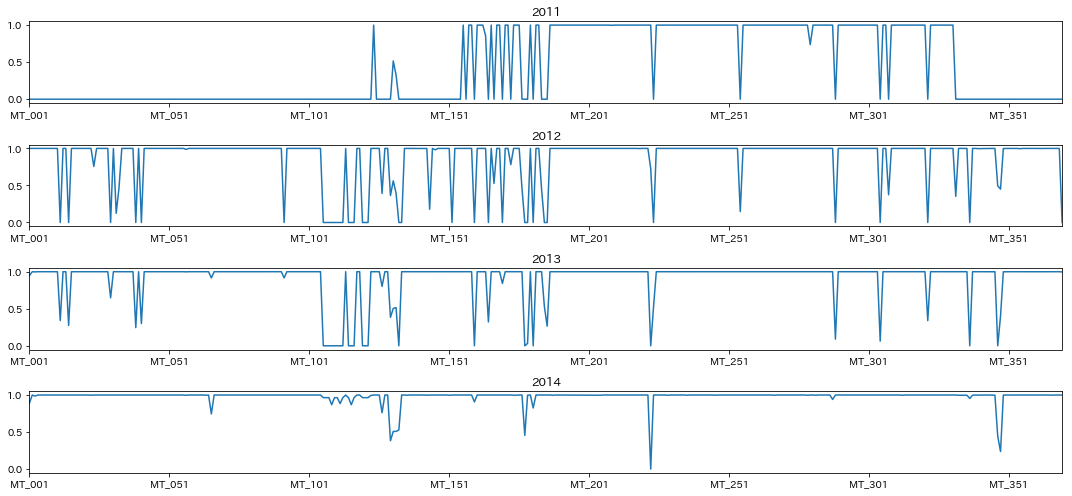

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(15, 7))

ax = axes.ravel()

for i, year in enumerate(range(2011, 2015)):
    data_year_ratio.loc[year, :].plot(ax=ax[i])
    ax[i].set_title(str(year))
    

fig.tight_layout()

In [8]:
data_year_ratio.loc[2014, :].sort_values(ascending=True).head()

MT_223    0.000000
MT_348    0.237329
MT_130    0.382449
MT_347    0.441096
MT_178    0.454766
Name: 2014, dtype: float64

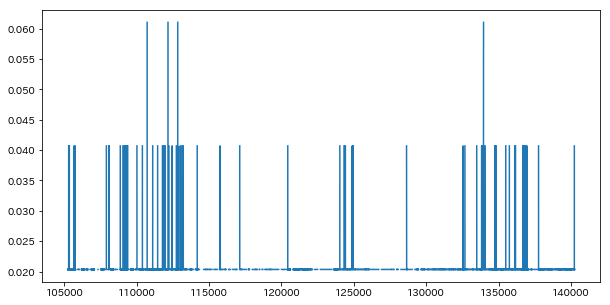

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(data[data['year'] >= 2014]['MT_348'])
plt.show()

In [10]:
# plt.figure(figsize=(15, 5))
# plt.plot(data[data['year'] >= 2014]['MT_130'])
# plt.show()

## 集計

- 2014年のデータのみを使用
    - データのないMT_223は集計しない
- 時間と曜日に分けて集計
- ScalerにMinMaxScalerを使用する。生データのままクラスタリングすると、消費電力の大小でクラスタリングされる

In [11]:
data_2014 = data[data['year'] >= 2014].copy()

In [12]:
data_2014.drop('MT_223', axis=1, inplace=True)

In [13]:
clients_col.remove('MT_223')
len(data_2014)

35040

In [14]:
data_agg = data_2014.groupby(['hour', 'dow'])[clients_col].mean()

In [15]:
#data_agg = data_agg.T
data_agg.head()

MT_001    MT_002    MT_003    MT_004    MT_005    MT_006  \
hour dow                                                               
0    0    0.001946  0.011997  0.000869  0.065593  0.027835  0.079878   
     1    0.001843  0.011898  0.000869  0.064743  0.028544  0.085322   
     2    0.002047  0.011732  0.000869  0.065683  0.028276  0.085397   
     3    0.002041  0.012018  0.000869  0.064523  0.028908  0.086789   
     4    0.002401  0.011647  0.000869  0.065813  0.028899  0.084707   

            MT_007    MT_008    MT_009    MT_010  ...    MT_361     MT_362  \
hour dow                                          ...                        
0    0    0.002821  0.105672  0.023610  0.025548  ...  0.054678  13.381731   
     1    0.003358  0.110374  0.024064  0.025571  ...  0.053854  13.365385   
     2    0.003382  0.108872  0.024612  0.026227  ...  0.056516  12.834434   
     3    0.003502  0.109686  0.024291  0.026194  ...  0.055513  12.786538   
     4    0.003579  0.111370  0.024009  0.026199  ...  0.055596  13.071635   

            MT_363    MT_364    MT_365    MT_366    MT_367    MT_368  \
hour dow                                                               
0    0    0.539303  0.671274  0.018704  0.004110  0.284023  0.024103   
     1    0.525661  0.709135  0.023687  0.011939  0.370994  0.097077   
     2    0.533198  0.689644  0.023816  0.003868  0.365477  0.097879   
     3    0.520580  0.717493  0.020522  0.011904  0.344535  0.095957   
     4    0.521472  0.718859  0.022506  0.004255  0.372923  0.094312   

            MT_369    MT_370  
hour dow                      
0    0    0.336787  8.000782  
     1    0.377723  9.169179  
     2    0.384685  9.127996  
     3    0.374545  8.966345  
     4    0.389168  8.971284  

[5 rows x 369 columns]

In [16]:
data_agg_hour = data_agg.mean(level='hour', axis=0)
data_agg_dow = data_agg.mean(level='dow', axis=0)

In [17]:
data_agg_hour.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,
0,0.002026,0.011946,0.000869,0.066531,0.029080,0.085634,0.003322,0.111970,0.024378,0.026251,...,0.060010,13.511684,0.535867,0.707482,0.021040,0.007751,0.341545,0.075095,0.373449,8.798375
1,0.002098,0.010525,0.000993,0.055847,0.026113,0.072740,0.002970,0.099823,0.023075,0.024344,...,0.044307,8.883044,0.388702,0.544101,0.018433,0.007097,0.326468,0.062266,0.365492,8.822450
2,0.002073,0.010022,0.000853,0.050661,0.024156,0.067006,0.002869,0.092033,0.022116,0.023183,...,0.038197,7.764790,0.358110,0.514587,0.017733,0.005318,0.302525,0.045015,0.366692,8.786818
3,0.002081,0.009811,0.000838,0.049095,0.023320,0.063147,0.002828,0.106512,0.021606,0.022839,...,0.033728,6.882267,0.336680,0.489693,0.017041,0.004140,0.273108,0.037916,0.356555,8.677977
4,0.002122,0.010026,0.000853,0.047532,0.022676,0.061511,0.002807,0.098333,0.021266,0.022573,...,0.034436,6.032027,0.325431,0.472920,0.016524,0.003788,0.259609,0.034038,0.350339,8.640943


In [18]:
data_agg_dow.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
dow,,,,,,,,,,,,,,,,,,,,,
0,0.002179,0.013432,0.000837,0.059161,0.026496,0.092382,0.002658,0.123932,0.026307,0.030178,...,0.141858,23.692026,1.111962,1.824306,0.040903,0.006891,0.282420,0.069691,0.406700,8.675369
1,0.002375,0.013273,0.000860,0.059416,0.026690,0.096321,0.003042,0.128131,0.026431,0.028748,...,0.140960,23.869283,1.113864,1.813267,0.042228,0.004712,0.299488,0.079282,0.422297,9.239730
2,0.002418,0.013330,0.000869,0.059230,0.026377,0.093844,0.003018,0.126299,0.026400,0.029332,...,0.140003,23.759967,1.097545,1.824046,0.041967,0.006896,0.293999,0.077853,0.415899,8.978683
3,0.002410,0.013206,0.000864,0.059714,0.026353,0.095546,0.003226,0.126121,0.026226,0.028979,...,0.141157,23.908634,1.098224,1.834893,0.041891,0.004981,0.297782,0.077813,0.425398,9.095780
4,0.002580,0.013211,0.000851,0.060147,0.026163,0.094134,0.003187,0.129747,0.026089,0.029272,...,0.145293,24.250400,1.169726,1.855910,0.042870,0.007117,0.306474,0.077050,0.426561,9.247780


In [19]:
data_agg.T[data_agg.isnull().any(axis=0)]

hour          0                                                               \
dow            0         1         2         3         4         5         6   
MT_130  0.068948  0.100078  0.100142  0.102398  0.100556  0.099543  0.055088   

hour          1                       ...        22                      \
dow            0         1         2  ...         4         5         6   
MT_130  0.071323  0.029573  0.030543  ...  0.075549  0.104396  0.073436   

hour          23                                                             
dow            0         1         2         3        4         5         6  
MT_130  0.096154  0.068681  0.047453  0.075549  0.07326  0.094437  0.075285  

[1 rows x 168 columns]

In [20]:
data_agg['MT_130'] = data_agg['MT_130'].droplevel(level='dow').fillna(data_agg_hour['MT_130']).values

クライアント毎にスケーリング

In [21]:
scaler = MinMaxScaler()
data_agg[clients_col] = scaler.fit_transform(data_agg[clients_col])

In [22]:
data_agg.head()

MT_001    MT_002    MT_003    MT_004    MT_005    MT_006  \
hour dow                                                               
0    0    0.047928  0.363996  0.333333  0.460742  0.487706  0.269296   
     1    0.017597  0.349654  0.333333  0.445972  0.523722  0.325504   
     2    0.077332  0.325677  0.333333  0.462310  0.510106  0.326276   
     3    0.075468  0.366964  0.333333  0.442153  0.542177  0.340646   
     4    0.180525  0.313304  0.333333  0.464562  0.541730  0.319152   

            MT_007    MT_008    MT_009    MT_010  ...    MT_361    MT_362  \
hour dow                                          ...                       
0    0    0.361956  0.208390  0.305588  0.447142  ...  0.112053  0.223304   
     1    0.576630  0.258134  0.323181  0.448002  ...  0.107930  0.222828   
     2    0.586485  0.242236  0.344418  0.472268  ...  0.121259  0.207359   
     3    0.634239  0.250856  0.331977  0.471038  ...  0.116237  0.205964   
     4    0.665217  0.268664  0.321063  0.471229  ...  0.116650  0.214270   

            MT_363    MT_364    MT_365    MT_366    MT_367    MT_368  \
hour dow                                                               
0    0    0.121635  0.083312  0.105553  0.115950  0.519910  0.016894   
     1    0.114130  0.098177  0.209601  0.745588  0.890072  0.695021   
     2    0.118276  0.090524  0.212276  0.096506  0.866589  0.702478   
     3    0.111334  0.101459  0.143508  0.742760  0.777457  0.684617   
     4    0.111825  0.101995  0.184931  0.127602  0.898282  0.669327   

            MT_369    MT_370  
hour dow                      
0    0    0.065829  0.148812  
     1    0.293845  0.627149  
     2    0.332623  0.610289  
     3    0.276146  0.544110  
     4    0.357593  0.546132  

[5 rows x 369 columns]

クラスタリング用に転置

In [23]:
data_agg = data_agg.T
data_agg.head()

hour          0                                                               \
dow            0         1         2         3         4         5         6   
MT_001  0.047928  0.017597  0.077332  0.075468  0.180525  0.053210  0.045197   
MT_002  0.363996  0.349654  0.325677  0.366964  0.313304  0.377102  0.399357   
MT_003  0.333333  0.333333  0.333333  0.333333  0.333333  0.333333  0.333333   
MT_004  0.460742  0.445972  0.462310  0.442153  0.464562  0.512266  0.551311   
MT_005  0.487706  0.523722  0.510106  0.542177  0.541730  0.610191  0.640849   

hour          1                       ...        22                      \
dow            0         1         2  ...         4         5         6   
MT_001  0.042526  0.068345  0.084320  ...  0.046139  0.000000  0.048954   
MT_002  0.156527  0.135014  0.118969  ...  0.526211  0.514342  0.567013   
MT_003  0.333333  0.333333  0.333333  ...  0.333333  0.333333  0.333333   
MT_004  0.265088  0.265428  0.287004  ...  0.793227  0.686614  0.707156   
MT_005  0.310304  0.403173  0.387888  ...  0.849505  0.842956  0.800392   

hour          23                                                              
dow            0         1         2         3         4         5         6  
MT_001  0.043416  0.086397  0.096550  0.157377  0.078764  0.053383  0.033606  
MT_002  0.475025  0.456973  0.486773  0.400841  0.467112  0.478239  0.485411  
MT_003  0.333333  0.333333  0.333333  0.333333  0.333333  0.333333  0.333333  
MT_004  0.592819  0.596978  0.597391  0.598761  0.635260  0.644173  0.565487  
MT_005  0.821525  0.803964  0.847848  0.826734  0.786997  0.794885  0.700678  

[5 rows x 168 columns]

In [24]:
data_agg.loc[data_agg.isnull().sum(axis=1) > 1]

Empty DataFrame
Columns: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5), (12, 6), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (14, 0), (14, 1), ...]
Index: []

[0 rows x 168 columns]

## 次元削減

- 元の次元のままPCAをかけて、累積寄与率を確認する

In [25]:
pca = PCA(n_components=len(data_agg.columns) ,random_state=42)
pca.fit(data_agg)

PCA(copy=True, iterated_power='auto', n_components=168, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

<BarContainer object of 10 artists>

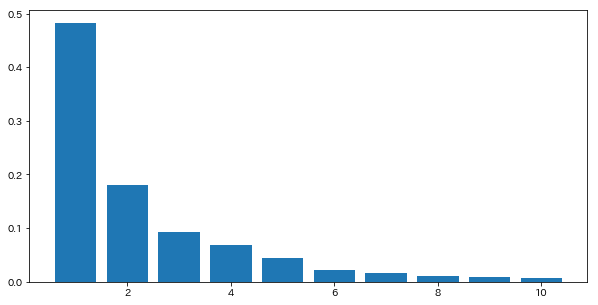

In [26]:
# 元の特徴量と同じ数で主成分分析
plt.figure(figsize=(10, 5))
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_[:10])+1)], pca.explained_variance_ratio_[:10] ,align="center")

In [27]:
np.set_printoptions(precision=5, suppress=True)
print('explained variance ratio: {}'.format(pca.explained_variance_ratio_.cumsum()[:10]))

explained variance ratio: [0.48248 0.66357 0.75564 0.8244  0.86874 0.8901  0.90621 0.91705 0.92536
 0.93248]


第4成分で累積寄与率が80%を超えるのでn_components=4としてPCAをかける

## Kmeans
- エルボー法でクラスタ数を算出

In [28]:
pca = PCA(n_components=4 ,random_state=42)
data_agg_pca = pca.fit_transform(data_agg)

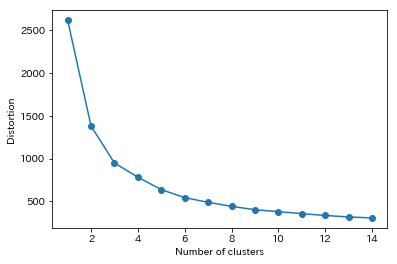

In [29]:
distortions = []

for i  in range(1,15):               
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(data_agg_pca)                     
    distortions.append(km.inertia_)

plt.plot(range(1,15),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

3,4,5あたりが有力か...  
それぞれでクラスタリングを行って、解釈を引き出せるクラスタ数を見つける

In [30]:
def plot_trend(agg_hour, agg_dow):
    fig, axes = plt.subplots(2,1 , figsize=(10, 8))

    ax = axes.ravel()

    handles = []
    for label in agg_hour.index:
            a, = ax[0].plot(agg_hour.iloc[label, :], label=label)
            peek = agg_hour.iloc[label, :].sort_values(ascending=False)[:5]
            ax[0].plot(peek, 'o', c='k', label=None)
            handles.append(a)

    ax[0].set_xticks(range(0, 24))
    ax[0].set_xlim(0, 23)
    ax[0].grid(True)
    ax[0].legend(handles, agg_hour.index)

    for label in agg_dow.index:
            ax[1].plot(agg_dow.iloc[label, :], label=label)

    ax[1].set_xticks(range(0, 7))
    ax[1].set_xlim(0, 6)
    ax[1].grid(True)
    ax[1].legend()

    fig.tight_layout()

### クラスタ数 3

In [31]:
km = KMeans(n_clusters=3 , random_state=42)
data_agg.loc[:, 'label'] = km.fit_predict(data_agg_pca)

In [32]:
cluster_result_agg = data_agg.groupby('label').mean()

In [33]:
cluster_result_agg_hour = cluster_result_agg.mean(level='hour', axis=1)
cluster_result_agg_dow = cluster_result_agg.mean(level='dow', axis=1)

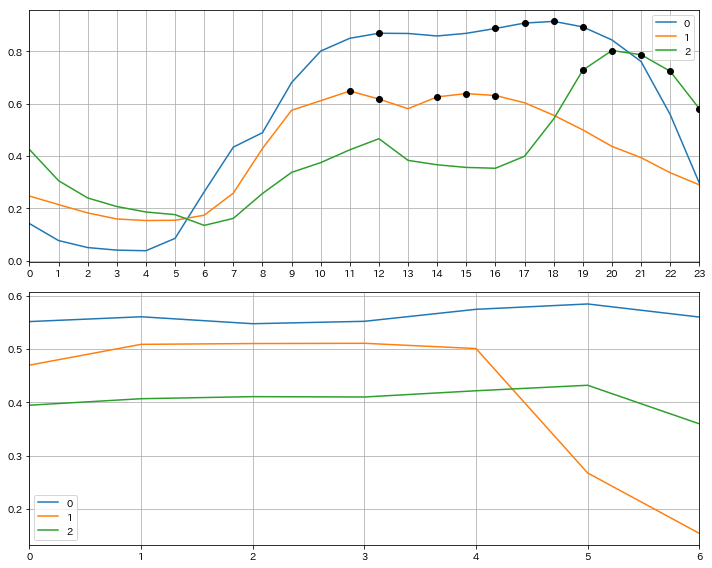

In [34]:
plot_trend(cluster_result_agg_hour, cluster_result_agg_dow )

### クラスタ数4

In [35]:
km = KMeans(n_clusters=4 , random_state=42)
data_agg.loc[:, 'label'] = km.fit_predict(data_agg_pca)

cluster_result_agg = data_agg.groupby('label').mean()

cluster_result_agg_hour = cluster_result_agg.mean(level='hour', axis=1)
cluster_result_agg_dow = cluster_result_agg.mean(level='dow', axis=1)

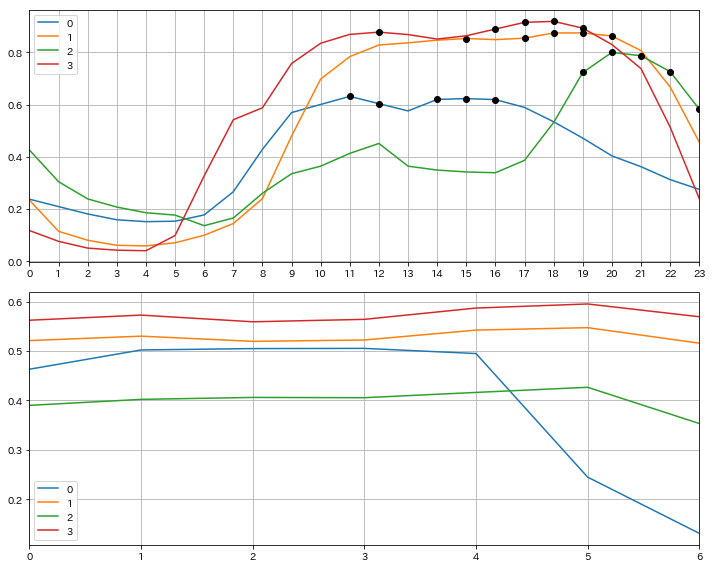

In [36]:
plot_trend(cluster_result_agg_hour, cluster_result_agg_dow )

- クラスタ2：夕方にかけて急激に上昇
    - 夕方すぎにの在宅の可能性が高い、共働き一人暮らしタイプ
    
    
- クラスタ0:夕方にかけて急激に現象
    - 夕方に在宅の可能性は低い夜勤タイプ
    - 夜勤だと起床時間はもう少し遅めでは....？もう少し上昇傾向が遅めだと説得力があるのだが....
    
    
- クラスタ1と3使用量増減傾向は似ている。朝から使用量が上がり、夜に下がり始める
    - 朝から日中にかけて在宅傾向がある在宅ワーカー、専業主婦(主夫)がいるタイプ
    - クラス3は8時から上がりはじめて、20時に下がり始める。一番一般的な印象。
    - クラスタ1は(クラスタ3より早い)5時から上がりはじめて、19時に下がり始める。早寝早起き。
    - 日中ならだいたいいるだろうが、1と3の再配達だったら1を優先した方がいい印象

### クラスタ数5

In [37]:
km = KMeans(n_clusters=5 , random_state=42)
data_agg.loc[:, 'label'] = km.fit_predict(data_agg_pca)

cluster_result_agg = data_agg.groupby('label').mean()

cluster_result_agg_hour = cluster_result_agg.mean(level='hour', axis=1)
cluster_result_agg_dow = cluster_result_agg.mean(level='dow', axis=1)

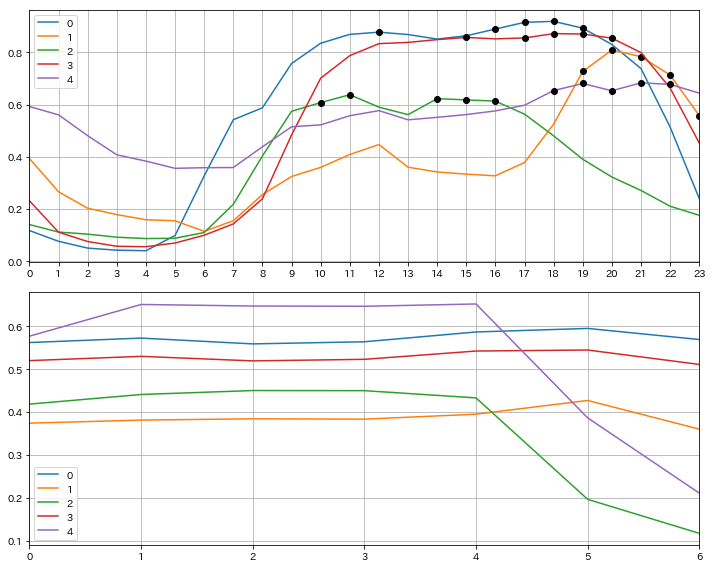

In [38]:
plot_trend(cluster_result_agg_hour,cluster_result_agg_dow  )

クラスタ4が解釈しづらい
- 0と3同様に、夜遅くまで上昇傾向からおそらく3と4から夜の時間帯に電力消費が落ちないグループがここに分類された印象

クラスタ数4がおそらくベスト  

In [57]:
km = KMeans(n_clusters=4 , random_state=42)
data_agg.loc[:, 'label'] = km.fit_predict(data_agg_pca)

cluster_result_agg = data_agg.groupby('label').mean()

cluster_result_agg_hour = cluster_result_agg.mean(level='hour', axis=1)
cluster_result_agg_dow = cluster_result_agg.mean(level='dow', axis=1)

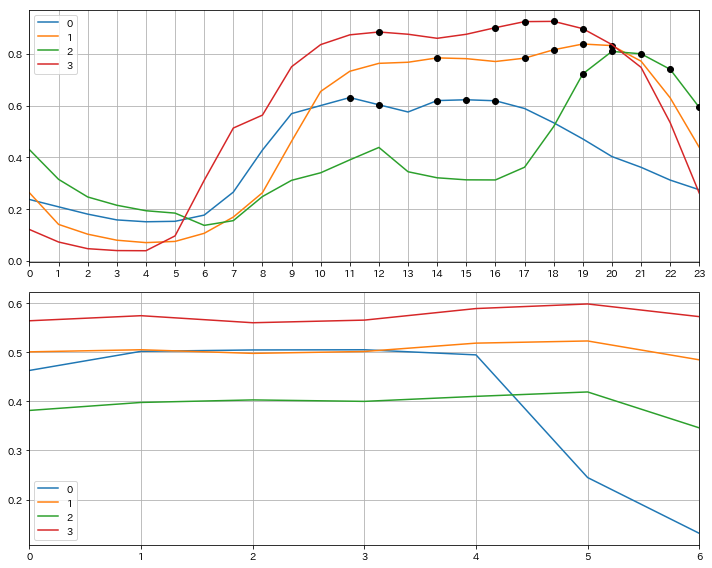

In [58]:
plot_trend(cluster_result_agg_hour, cluster_result_agg_dow)

- やはり平日の間では顕著な変化はない
- 全体的に日曜は減少傾向。やはり休みには外出する傾向にある
- ただ、クラスタ0は土日の減少が顕著で土日に在宅の可能性は低い

各クラスタにどのくらいのクライアントがグループされたか

In [41]:
labe_counts = data_agg.groupby('label').size()

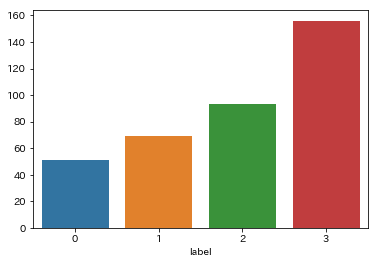

In [42]:
sns.barplot(y=labe_counts, x=labe_counts.index)

やっぱりクラスタ0は異質?

In [65]:
#data_agg[data_agg['label'] == 1].groupby('hour' , as_index=False).plot

# 結果から得られた今後の施策
- クラスタリングにクライアントをグループ分けができた
    - 共働き一人暮らしタイプ
    - 在宅ワーカー、専業主婦(主夫)がいるタイプ。早寝早起き
    - 日中の早い時間に在宅可能性が高い夜勤タイプ
 
 
- そもそも再配達するドライバーがクライアントの傾向を一番知っているはず。この結果を現場に伝えて現場感と一致しているかをヒアリングしてみる
    - 異なる => データのクリーニング、モデリングをやり直す、他の特徴量(家族構成、家の大きさ、地域、etc)を入れてみる
    - だいたい合っている => 電気使用量によって在宅の傾向を掴める可能性が出てきたので、クライアントのクラスタを伝えて A/B テストで再配達率を定量してみる

In [56]:
data_agg.loc['MT_001']['label']

dow
    3.0
Name: MT_001, dtype: float64

## さらに...
- 外れ値の処理を考慮してみる
- 平日と週末分けて分析してみる
- クラスタ結果の解釈は最大値のみを考慮している。なにか基準を設けて(最小値？)、在宅確率みたいなものをアウトプットできたらよさそう


## 参考回答
- クラスタ毎の平均使用量の差で各家庭の名前をつけるのもあり
- バックテスト : 過去のデータと付け合わせる。本当にいるような時間帯でクラスタリングできたかどうか
- StanderdScalerを用いれば0が平均になるので、平均より小さい、大きいを言える

## 追加の分析
### T-SNEとNMF

- やはりクラスタ0は少ない

In [43]:
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [44]:
pca = PCA(n_components=2 ,random_state=42)
data_agg_pca = pca.fit_transform(data_agg)

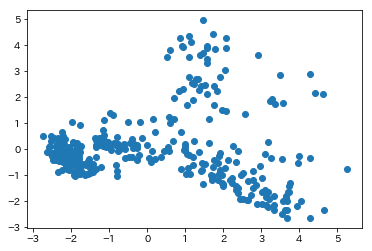

In [45]:
plt.plot(data_agg_pca[:, 0 ], data_agg_pca[:, 1], 'o')

NMF

In [46]:
nmf = NMF(n_components=2 ,random_state=42)
data_agg_nmf = nmf.fit_transform(data_agg)

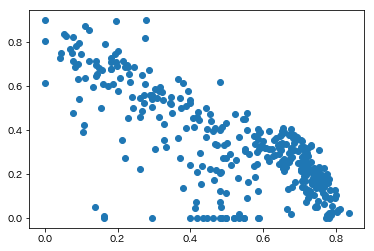

In [47]:
plt.plot(data_agg_nmf[:, 0 ], data_agg_nmf[:, 1], 'o')

TSNE

In [48]:
tsne = TSNE(random_state=42)
data_agg_tsne = tsne.fit_transform(data_agg)

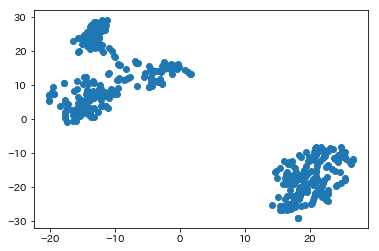

In [49]:
plt.plot(data_agg_tsne[:, 0 ], data_agg_tsne[:, 1], 'o')

T-SNEの結果でk-meanを実行して元のデータセットにラベリングしてみる

In [50]:
km = KMeans(n_clusters=4 , random_state=42)
cluster_label = km.fit_predict(data_agg_tsne)

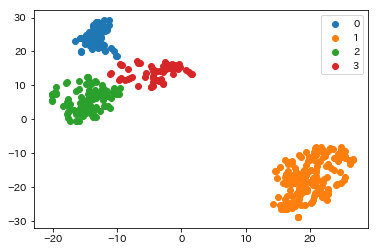

In [51]:
fig, ax = plt.subplots(1,1)

for i in list(np.unique(cluster_label)):
    cluster = data_agg_tsne[cluster_label==i]
    ax.scatter(cluster[:, 0], cluster[:, 1], label=i)
    
ax.legend()

In [52]:
data_agg.loc[:, 'label'] = cluster_label

cluster_result_agg = data_agg.groupby('label').mean()

cluster_result_agg_hour = cluster_result_agg.mean(level='hour', axis=1)
cluster_result_agg_dow = cluster_result_agg.mean(level='dow', axis=1)

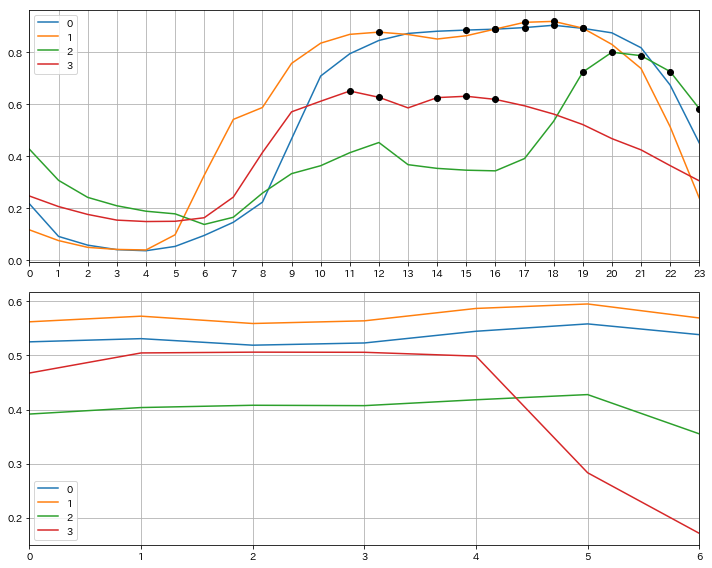

In [53]:
plot_trend(cluster_result_agg_hour, cluster_result_agg_dow)

時系列でプロットでは近そうに思っていたクラスタ0と1は2次元上では離れていた。直感と異なる結果になった。
- 2次元上では別の要素でみている？